# Ordinal Regression for Identifying Severity of Hyperbolic Marketing in YouTube Video Titles

Authors: Marlon Fu, Wendy Kim, Sean Wei

This notebook presents an overview of classifying hyperbolic marketing in YouTube video titles, more commonly known as "clickbait". This project was originally designed as a final project for [Info 159: Natural Language Project](https://people.ischool.berkeley.edu/~dbamman/nlp23.html) at UC Berkeley, taught by [Professor David Bamman](https://people.ischool.berkeley.edu/~dbamman/).

Clickbait titles are known to utilize sensational language to attract users’ attention, but often include exaggerated and misleading claims. Creating a clickbait classifier through our annotation project would enable two things: 1. false claims or claims blown out of proportion can be detected to hide videos from young or vulnerable viewers on Youtube 2. Labeling clickbait may help in the analysis of video click rate and performance by creators. For our project, we will be considering a few approaches.

## Table of Contents
* [The Data](#the-data)
* [Data Pre-Processing](#data-pre-processing)
* [Feature Selection](#feature-selection)
* [Ordinal Regression](#ordinal-regression)
* [Evaluating Model Performance](#evaluating-model-performance)

In [1]:
import pandas as pd
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm

import OrdinalRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /Users/MarlonFu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## The Data <a class="anchor" id="the-data"></a>

This dataset is taken from the ["YouTube Statistics" dataset published by Advay Patil on Kaggle](https://www.kaggle.com/datasets/advaypatil/youtube-statistics?select=videos-stats.csv). The data is neither private nor under copyright, and can be freely distributed with others. The original file found on Kaggle includes various statistics in addition to the title for each YouTube video within the dataset. Some features include the video ID, the date of publications, and the numbers of views, comments, and likes the video received by users. However, for the purposes of this project, only the titles of each video will be analyzed, as these serve as the documents for which we can identify clickbait.

In the dataset of YouTube video titles, the categories we are considering to annotate are related to clickbait.  One approach of classification would be the implementation of the binary labels of “clickbait” or “not clickbait”. While this would enable us to be more objective in our decisions, there are less guidelines to define and comprehensively follow. For a second approach, we can assign a value to the YouTube video titles on an ordinal scale of 1-5 (5 being the most significantly clickbait). This method would incorporate further subjective decision-making, as humans consider how clickbait a video title is or not. Clickbait becomes more of a relative characteristic in this second method, as we can place YouTube video titles into tiers somewhat. Under both methods, the labels are not necessarily deterministic, as deciding that a video is clickbait requires human context. 

The methodology for annotating this dataset with labels is as follows:
1. Data is split into two batches: one for exploring the data and another to be annotated with labels. 
2. Based on the exploration set, the project group will collectively agree on a set of annotation guidelines, outlined in `annotation_guidelines.pdf`
2. Using `annotation_guidelines.pdf`, two group members will individually annotate the remaining data such that each row receives two labels.
3. The third group member will adjudicate each annotation and decide on a final label to give each row. 

This process is documented in `annotation_results.xlsx`



## Data Pre-Processing <a class="anchor" id="data-pre-processing"></a>

In [2]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/MarlonFu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/MarlonFu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/MarlonFu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def remove_stopwords(word_list):
    return [word for word in word_list if word not in stopwords.words('english')]

def stem_words(word_list):
    ps = PorterStemmer()
    return [ps.stem(word) for word in word_list]

def lemmatize_words(word_list):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(word) for word in word_list]

def repeated_words(text):
    feats = {}
    words = nltk.word_tokenize(text)
    words = remove_stopwords(words)
    words = lemmatize_words(words)

    word_counter = {}
    for word in words:
        word = word.lower()
        if word not in word_counter:
            word_counter[word] = 1
        else:
            word_counter[word] += 1
    
    word_counter = sorted(word_counter.items(), key=lambda x:x[1], reverse=True)

    feats['Count of highest repeated word'] = word_counter[0][1]
    return feats

## Feature Selection <a class="anchor" id="feature-selection"></a>

In [5]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1
            
    return feats


def bag_of_words(text):
    feats = {}
    words = nltk.word_tokenize(text)
    for word in words:
        word = word.lower()
        if word in feats:
            feats[word] += 1
        else:
            feats[word] = 1
    return feats


def repeated_punctuation(text):
    """sequences of exclamation points or question marks"""
    feats = {}
    words = nltk.word_tokenize(text)
    for word in words:
        if word == "!!" or word == "!!!":
            if 'punctuation' in feats.keys():
                feats['punctuation'] += 1
            else:
                feats['punctuation'] = 1
    return feats


def proportion_capital(text):
    """proportion of capital letters"""
    feats = {}
    feats['Prop'] = sum([i.isupper() for i in text]) / len(text)
    return feats


def prop_cap_category(text):
    proportion =  sum([i.isupper() for i in text]) / len(text)
    feats = {}
    if proportion <= 0.9:
        if 'low' in feats.keys():
            feats['low'] += proportion
        else:
            feats['low'] = proportion
    else:
        if 'high' in feats.keys():
            feats['high'] += proportion
        else:
            feats['high'] = proportion
    return feats


def personal(text):
    """use of personal language"""
    feats = {}
    words = nltk.word_tokenize(text)
    for word in words:
        word = word.lower()
        if word == "you" or word == "your" or word == "i":
            if 'personal' in feats.keys():
                feats['personal'] += 1
            else:
                feats['personal'] = 1
    return feats


def prop_cap(text):
    return sum([i.isupper() for i in text]) / len(text)


def prop_digits(text):
    """Proportion of characters that are numerical"""
    feats = {}
    feats['prop_digits'] = sum([i.isdigit() for i in text]) / len(text)
    return feats


def superlatives(text):
    """use of superlatives"""
    feats = {}
    words = nltk.word_tokenize(text)
    for word in words:
        word = word.lower()
        if word == "most" or word == "best" or word == "worst" or word == "never":
            if 'superlative' in feats.keys():
                feats['superlative'] += 1
            else:
                feats['superlative'] = 1
    return feats


def characters(text):
    feats = {}
    words = nltk.word_tokenize(text)
    for word in words:
        if word in [ '&', '#', ':', '~', '@', '&#', ';']:
            if word not in feats:
                feats[word] = 1

    return feats


def official_music_video(text):
    feats = {}
    words = nltk.word_tokenize(text)
    for word in words:
        word = word.lower()
        if word == "official" or word == 'music' or word == 'trailer':
            feats['official'] = 0
            return feats
    feats['official'] = 1
    return feats


def mentions_money(text):
    feats = {}
    if '$' in text:
        feats['mentions_money'] = 1
    else:
        feats['mentions_money'] = 0
    

    words = nltk.word_tokenize(text)
    for word in words:
        word = word.lower()
        if word == "dollar" or word == 'dollars':
            feats['mentions_money'] = 1

    return feats


def mentions_timerange(text):
    feats = {'time' : 0}
    words = nltk.word_tokenize(text)
    for word in words:
        word = word.lower()
        if word == "hours" or word == "weeks" or word == 'months' or word == "hour" or word == "week" or word =="month" or word == 'day' or word == 'days':
            feats['time'] = 1
    return feats

## Ordinal Regression <a class="anchor" id="ordinal-regression"></a>

In [6]:
import OrdinalRegression

def load_ordinal_data(filename, ordering):
    X = []
    Y = []
    orig_Y=[]
    for ordinal in ordering:
        Y.append([])
        
    with open(filename, encoding="utf-8") as file:
        for line in file:
            #print(filename)
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3].replace('\n', '')
            X.append(text)

            index=ordering.index(str(label))
            for i in range(len(ordering)):
                if index > i:
                    Y[i].append(1)
                else:
                    Y[i].append(0)
            orig_Y.append(label)
                    
    return X, Y, orig_Y

In [7]:
trainingFile = "splits/train.txt"
devFile = "splits/dev.txt"
testFile = "splits/test.txt"
    
ordinal_values=["1", "2", "3", "4", "5"]

In [8]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [9]:
features = [prop_digits, 
            binary_bow_featurize, 
            repeated_punctuation, 
            proportion_capital, 
            personal, 
            superlatives, 
            prop_cap_category, 
            characters, 
            official_music_video, 
            mentions_money, 
            mentions_timerange,
            ]


def combiner_function(text):
    all_feats={}
    for feature in features:
        all_feats.update(feature(text))
    return all_feats


from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

def get_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Figure 3: Confusion Matrix");
    plt.show()


# testing features with combiner_function 
def run(trainingFile, devFile, testFile, ordinal_values):


    trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)
    
    simple_classifier = OrdinalRegression.OrdinalClassifier(ordinal_values, combiner_function, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
    simple_classifier.train()
    
    metrics = simple_classifier.test()
    accuracy = metrics[0]
    errors = metrics[1]
    actual_values = metrics[2]
    predicted_values = metrics[3]


    lower, upper=confidence_intervals(accuracy, len(testY[0]), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))
    return pd.DataFrame({'Actual' : actual_values, 'Predicted' : predicted_values, 'Abs Error' : errors})

preds = run(trainingFile, devFile, testFile, ordinal_values)

Mean Absolute Error: 0.59
Median Absolute Error: 0.0
Test accuracy for best dev model: 0.550, 95% CIs: [0.452 0.648]



## Evaluating Model Performance <a class="anchor" id="evaluating-model-performance"></a>

Some features that we didn't consider in our guidelines, that we might now rethink, became evident during our modeling process. For one, the presence of large quantities of numbers played a significant role in our model. This is likely due to many clickbait titles using large sums of money or high test scores or significant time crunches to attract viewers attention. The latter also held an impact in our model, as titles with certain quantities of time, such as "year", "month", "week", etc. Some of the features that we expected to positively contribute to the accuracy include the proportion of capital letters in the title, as well as the use of repeated exclamation points and question marks. However, interestingly, adding a Boolean feature for whether or not the proportion of capital letters in a given text was above a certain threshold was more impactful than the raw proportion itself. Perhaps there was a disconnect between our general understanding and perception of clickbait YouTube video titles and our testing dataset. 

As seen in Figure 1, the bar plot below, the level of balance in our dataset is not necessarily ideal. We see a trend of decreasing frequencies as our labels increase, implying that clickbait videos are disproportionately represented. We recognized that this distribution of our data could have been hurting our feature selection; while we were primarily brainstorming features that would indicate clickbait videos, perhaps, we should have been brainstorming features that indicate legitimacy in YouTube videos. Some features that could particularly identify legitimate YouTube video titles could include the usage of proper capitalization or words that imply educational content. Furthermore, having 5 different levels to estimate Clickbait could have contributed more harm than help. Improving accuracy was a tricky process, as even being off by 1 label level would lower accuracy significantly. If further analysis is continued, we would experiment with lower granularity of labels to identify if our features are not insightful or if 5 labels was too many to reach a more significant accuracy. 

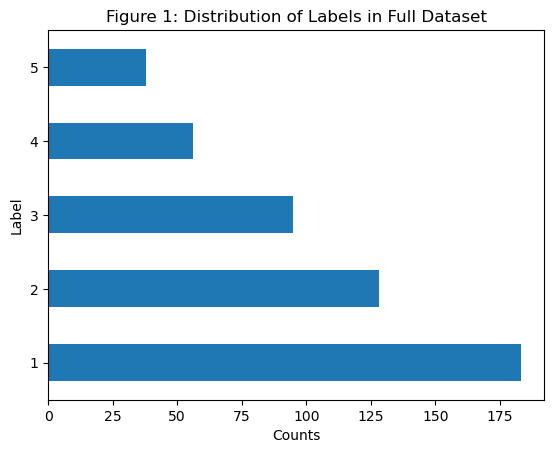

In [10]:
adjudicated = pd.read_csv('adjudicated.csv')
adjudicated['label'].value_counts().plot(kind='barh')
plt.title('Figure 1: Distribution of Labels in Full Dataset')
plt.ylabel('Label')
plt.xlabel('Counts');

To further understand the error of our model, we decided to observe the Mean Absolute Error and Median Absolute Error. Again, due to the higher granularity of our labels, as opposed to a binary scale, we made the conclusion that accuracy may not be an incredibly insightful metric. As we suspected, the Mean Absolute Error and Median Absolute Error affirmed that our struggle with improving accuracy was not as big of an issue as we thought. Respectively, we calculated a Mean Absolute Error and Median Absolute Error of 0.59 and 0. The Median Absolute Error can be explained due to more than half of our predictions matching their actual respective labels. However, the Mean Absolute Value proved that the direction of our predictions was promising. On average, our predictions were often off by at most 1 label, with 90% of predictions landing within 1 value of the actual label. If we were to refine our model analysis in the future, we would want to work towards first reducing the Mean Absolute Error to get our predictions as close to their adjudicated label, not necessarily exactly correct. Figure 2, below, extends this understanding visually, as the Distribution of Absolute Errors is notably right-skewed. We rarely have an error as significant as 3 or 4 magnitude, but, rather, we are very often just off by 1 level of clickbait that we assigned. 

In [11]:
prop_error_under_1 = preds[preds['Abs Error'] <= 1].shape[0] / preds.shape[0]
print("A proportion of " + str(prop_error_under_1) + " of our predictions were within 1 label of the actual value")

A proportion of 0.9 of our predictions were within 1 label of the actual value


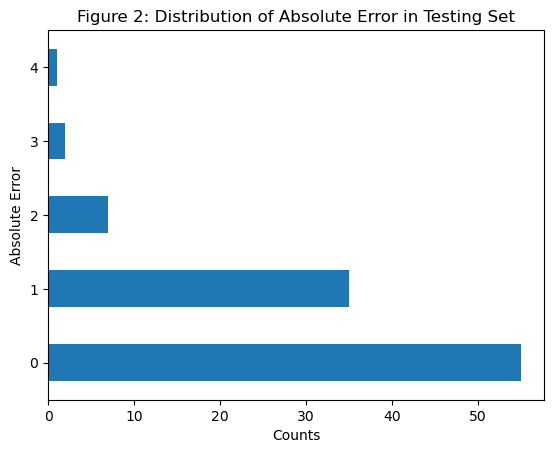

In [12]:
preds['Abs Error'].value_counts().plot(kind='barh')
plt.title('Figure 2: Distribution of Absolute Error in Testing Set')
plt.ylabel('Absolute Error')
plt.xlabel('Counts');

/Users/MarlonFu/opt/anaconda3/envs/clickbait/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/MarlonFu/opt/anaconda3/envs/clickbait/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/MarlonFu/opt/anaconda3/envs/clickbait/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/MarlonFu/opt/anaconda3/envs/clickbait/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

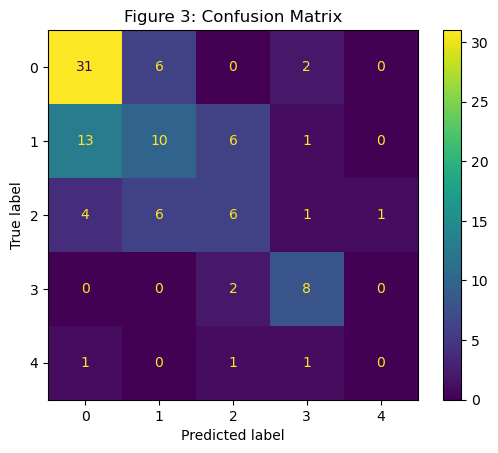

In [13]:
get_confusion_matrix(preds['Actual'], preds['Predicted'])

Finally, Figure 3, a Confusion Matrix of our predicted and true labels, highlights how the relatively poor accuracy of our model is more attributed to our guidelines and granularity of labels, rather than our regression features. As we brainstormed, our features did do an adequate job of directing our decisions towards significant clickbait or not. This is proven by the higher values on the diagonal of the matrix. In contrast, the lower values that are not near the diagonal of the matrix prove that we did not often observe significant disparities between the true clickbait label and the predicted. 